# 방문형 은행 서비스 제공 지역 추천
### (DBSCAN 사용 및 읍면동별 경제지표를 반영)

### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# 시각화 라이브러리
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# 클러스터링 관련 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 인과관계 분석 라이브러리
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [2]:
# 데이터 불러오기
df = pd.read_parquet('./data/jeonnam_clustered_mapped_ADMadd.parquet')

### 사용 함수 정의

In [3]:
def plot_distribution(df, cols=None, figsize=(10, 8), hue=None):
    '''데이터프레임의 컬럼들의 분포를 시각화합니다.'''
    if cols is None:
        cols = df.columns
    
    axes_rows = len(cols)//2 + len(cols)%2
    axes_cols = 2
    plt.rc('font', family='NanumGothic')
    fig, ax = plt.subplots(axes_rows, axes_cols, figsize=figsize)
    
    for i, col in enumerate(cols):
        sns.histplot(df[col], ax=ax[i//2, i%2], hue=hue)
        ax[i//2, i%2].set_title(f'{cols[i]} Distribution')
        ax[i//2, i%2].set_xlabel(f'{cols[i]}')
        
    plt.tight_layout()
    plt.show()

In [4]:
def plot_samples(df, grouping='', figsize=(10, 8), hue=None):
    '''샘플들을 지도가 아닌 일반 그래프로 시각화합니다. grouping 컬럼을 기준으로 색을 다르게 표시합니다.'''
    plt.figure(figsize=(10, 8))
    unique_labels = set(df[grouping])
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(df[grouping].unique()))]
    
    # 모든 점들을 투명도 높은 회색으로 시각화
    plt.scatter(df['mean_longitude'], df['mean_latitude'], c='gray', s=5, alpha=0.3)
    
    for k, col in zip(df[grouping].unique(), colors):
        class_member_mask = (df[grouping] == k)
        
        # 그룹에 속하는 점들만 시각화
        xy = df[class_member_mask & (df[grouping] != -1)]
        plt.plot(xy['mean_longitude'], xy['mean_latitude'], 'o', markerfacecolor=tuple(col), markersize=5)
    
    plt.title('Samples colored by ' + grouping)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.ylim(34.2, 35.5)
    plt.show()

## DBSCAN 파라미터 설정
DBSCAN을 샘플의 위도,경도에 적용하여 금융사막화 지역이 모여있는 군집들을 분류하겠습니다.

DBSCAN에 쓸 적당한 $\epsilon$ 값을 구하기 위하여 KNN으로 elbow point를 찾아주도록 하겠습니다.

In [5]:
# 금융 사막화 분류 클러스터만 추출
df_cluster_0 = df[df['cluster'] == 0]

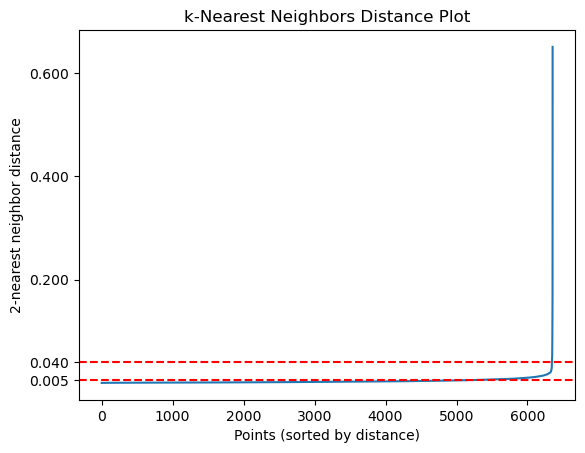

In [6]:
# 가까운 k개의 이웃 거리를 계산
k = 2  # DBSCAN의 min_samples와 같은 값으로 설정
nbrs = NearestNeighbors(n_neighbors=k).fit(df_cluster_0[['mean_latitude', 'mean_longitude']])
distances, indices = nbrs.kneighbors(df_cluster_0[['mean_latitude', 'mean_longitude']])

# 근처의 k개 이웃 거리를 정렬
distances = np.sort(distances[:, k-1])

# 좋은 eps 값을 찾기 위해 k 근처 이웃 거리를 시각화
plt.plot(distances)

# Elbow Point (좋은 eps 값의 범위)를 시각화한 그래프에 표시
plt.axhline(y=0.04, color='red', linestyle='--')
plt.axhline(y=0.005, color='red', linestyle='--')

plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{k}-nearest neighbor distance')
plt.yticks([0.005, 0.04, 0.2, 0.4, 0.6])
plt.title('k-Nearest Neighbors Distance Plot')
plt.show()

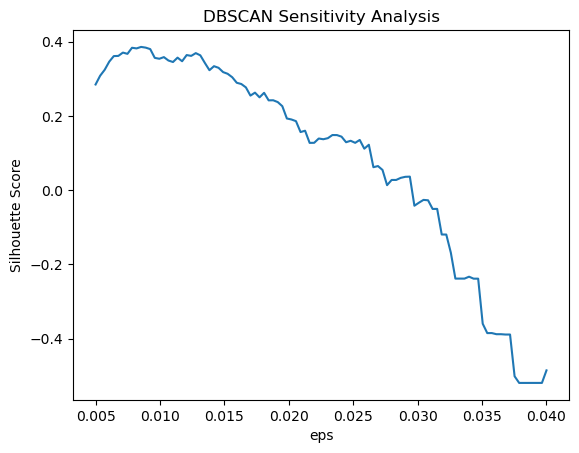

In [7]:
# 엡실론 값에 따른 DBSCAN 실루엣 점수 계산
eps_values = np.linspace(0.005, 0.04, 100)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=k)
    clusters = dbscan.fit_predict(df_cluster_0[['mean_latitude', 'mean_longitude']])
    silhouette_scores.append(silhouette_score(df_cluster_0[['mean_latitude', 'mean_longitude']], clusters))
    
plt.plot(eps_values, silhouette_scores)
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN Sensitivity Analysis')
plt.show()

In [8]:
# 파라미터를 정의하여 DBSCAN 모델을 학습
best_eps = 0.009
best_min_samples = 2
db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(df_cluster_0[['mean_latitude', 'mean_longitude']])
labels = db.labels_
silhouette_avg = silhouette_score(df_cluster_0[['mean_latitude', 'mean_longitude']], labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3860272135376117


군집 내 최소 샘플 개수 (k)를 2로 설정하고, 군집 내 최소 샘플 개수에 따른 k-Nearest Neighbors 거리를 시각화한 결과,\
Elbow Point가 0.005와 0.04 사이에 위치함을 확인할 수 있다. 

따라서, 이 범위 내에서 높은 실루엣 점수를 반환하는 0.009를 엡실론 값으로 사용하기로 했다.

---

## DBSCAN 시각화

In [9]:
# 클러스터링 결과를 데이터프레임에 추가
df_cluster_0.loc[:, 'DBSCAN_labels'] = labels

In [10]:
# 지도 객체 생성
f = folium.Figure(width=800, height=600)
m = folium.Map(location=[df_cluster_0['mean_latitude'].mean(), df_cluster_0['mean_longitude'].mean()], tiles='cartodbpositron',
               zoom_start=9, min_zoom=9).add_to(f)

# 고유 라벨 및 색상 설정
unique_labels = list(set(df_cluster_0['DBSCAN_labels']))
unique_labels.remove(-1)
spectral = plt.colormaps['Spectral']
tab20 = plt.colormaps['tab20']
np.random.seed(42)

# 색깔 스키마 정의
color_schemes = {
    'DBSCAN': {
        # Different color and stroke for each cluster
        'colors': {label: mcolors.to_hex(tab20(i / len(unique_labels))) for i, label in enumerate(unique_labels)},
        'opacities': {label: 0.8 for label in unique_labels},
        'strokes': {label: mcolors.to_hex(spectral(i / len(unique_labels))) for i, label in enumerate(np.random.permutation(unique_labels))}
    }
}

# 색상 스키마별 레이어를 추가
for scheme_name, scheme in color_schemes.items():
    colors = scheme['colors']
    opacities = scheme['opacities']
    strokes = scheme['strokes']
    feature_group = folium.FeatureGroup(name=scheme_name)
    
    for index, row in df_cluster_0.iterrows():
        cluster = row['DBSCAN_labels']
        color = colors.get(cluster, 'grey')  # Default to grey if cluster is not in color_map
        opacity = opacities.get(cluster, 0.2)  # Default opacity if not defined
        stroke = True
        stroke_color = strokes.get(cluster, 'black')  # Default to black if stroke is not defined
        
        folium.CircleMarker(location=[row['mean_latitude'], row['mean_longitude']], 
                            radius=3, stroke=stroke, color=stroke_color, weight=1 if cluster != -1 else 0,
                            fill=True, fill_color=color, fill_opacity=opacity).add_to(feature_group)
    
    feature_group.add_to(m)

# 레이어 컨트롤 추가
folium.LayerControl().add_to(m)

# 지도 저장 및 시각화
m

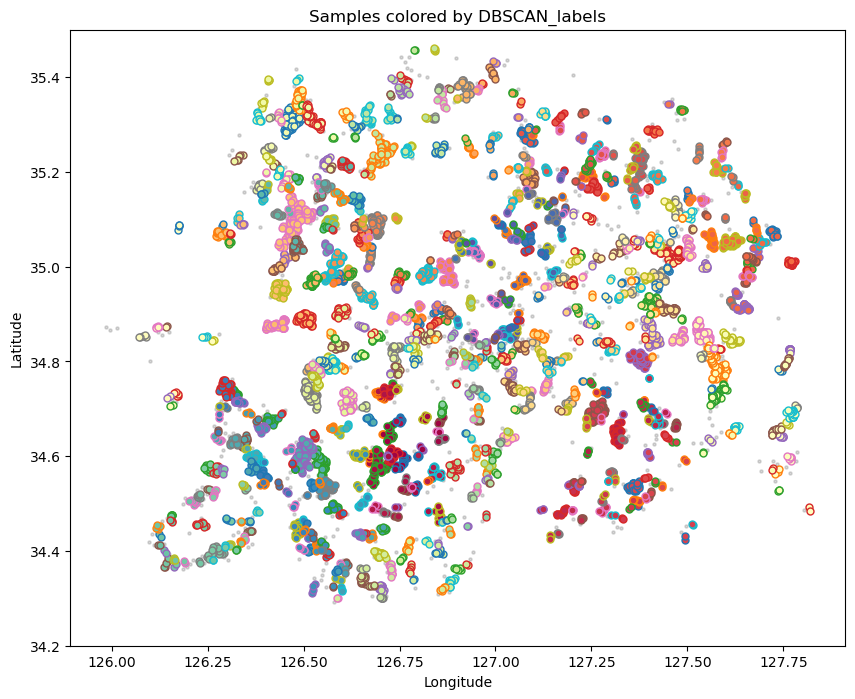

In [11]:
plot_samples(df_cluster_0, 'DBSCAN_labels')

군집으로 분류된 샘플들에겐 색깔을 부여하고, 분류되지 않은 샘플들은 회색으로 시각화 했다.

---
## 경제지표 데이터 분석

In [12]:
# 데이터 불러오기
df_econ = pd.read_csv('./data/jeonnam_econ.csv', encoding='cp949')

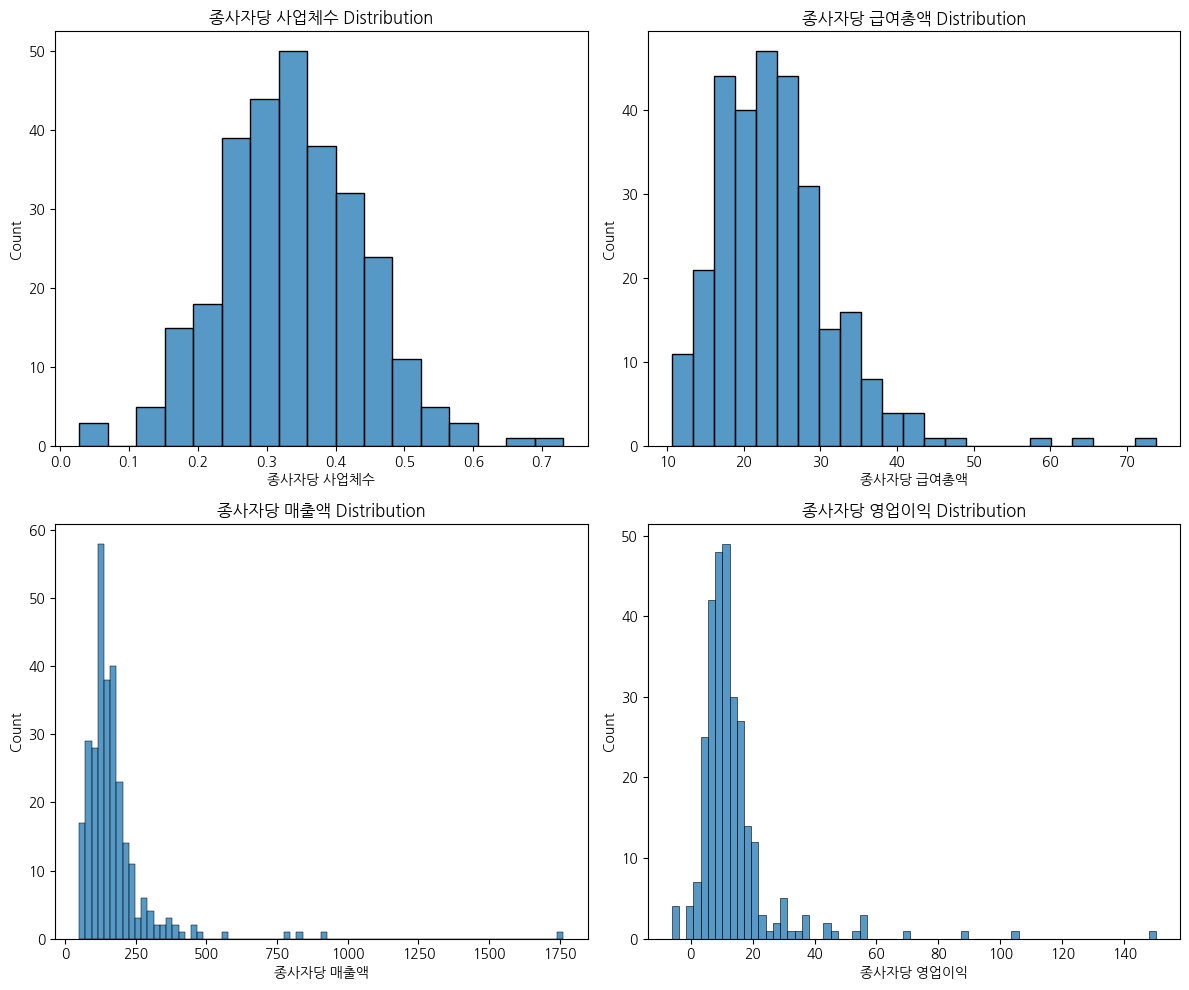

In [13]:
# 경제지표 컬럼 정의
econ_vars = ['종사자당 사업체수', '종사자당 급여총액', '종사자당 매출액', '종사자당 영업이익']

# 경제지표 분포 시각화
plot_distribution(df_econ, cols=econ_vars, figsize=(12, 10))

c:\Users\YuHan\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\Users\YuHan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


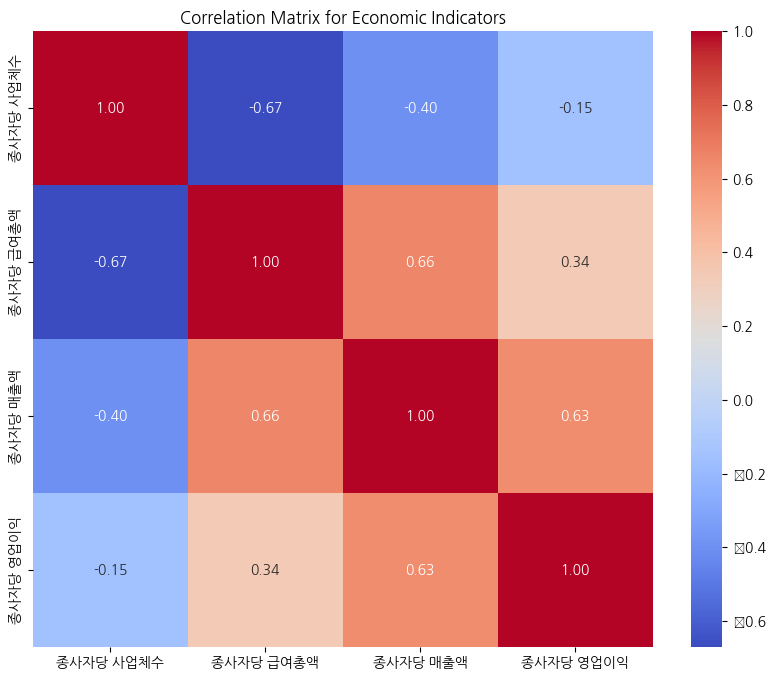

In [14]:
# 경제지표 상관관계 히트맵
corr = df_econ[econ_vars].corr()
plt.figure(figsize=(10, 8))
plt.rc('font', family='NanumGothic')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Economic Indicators')
plt.show()

c:\Users\YuHan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1000 with 0 Axes>

c:\Users\YuHan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


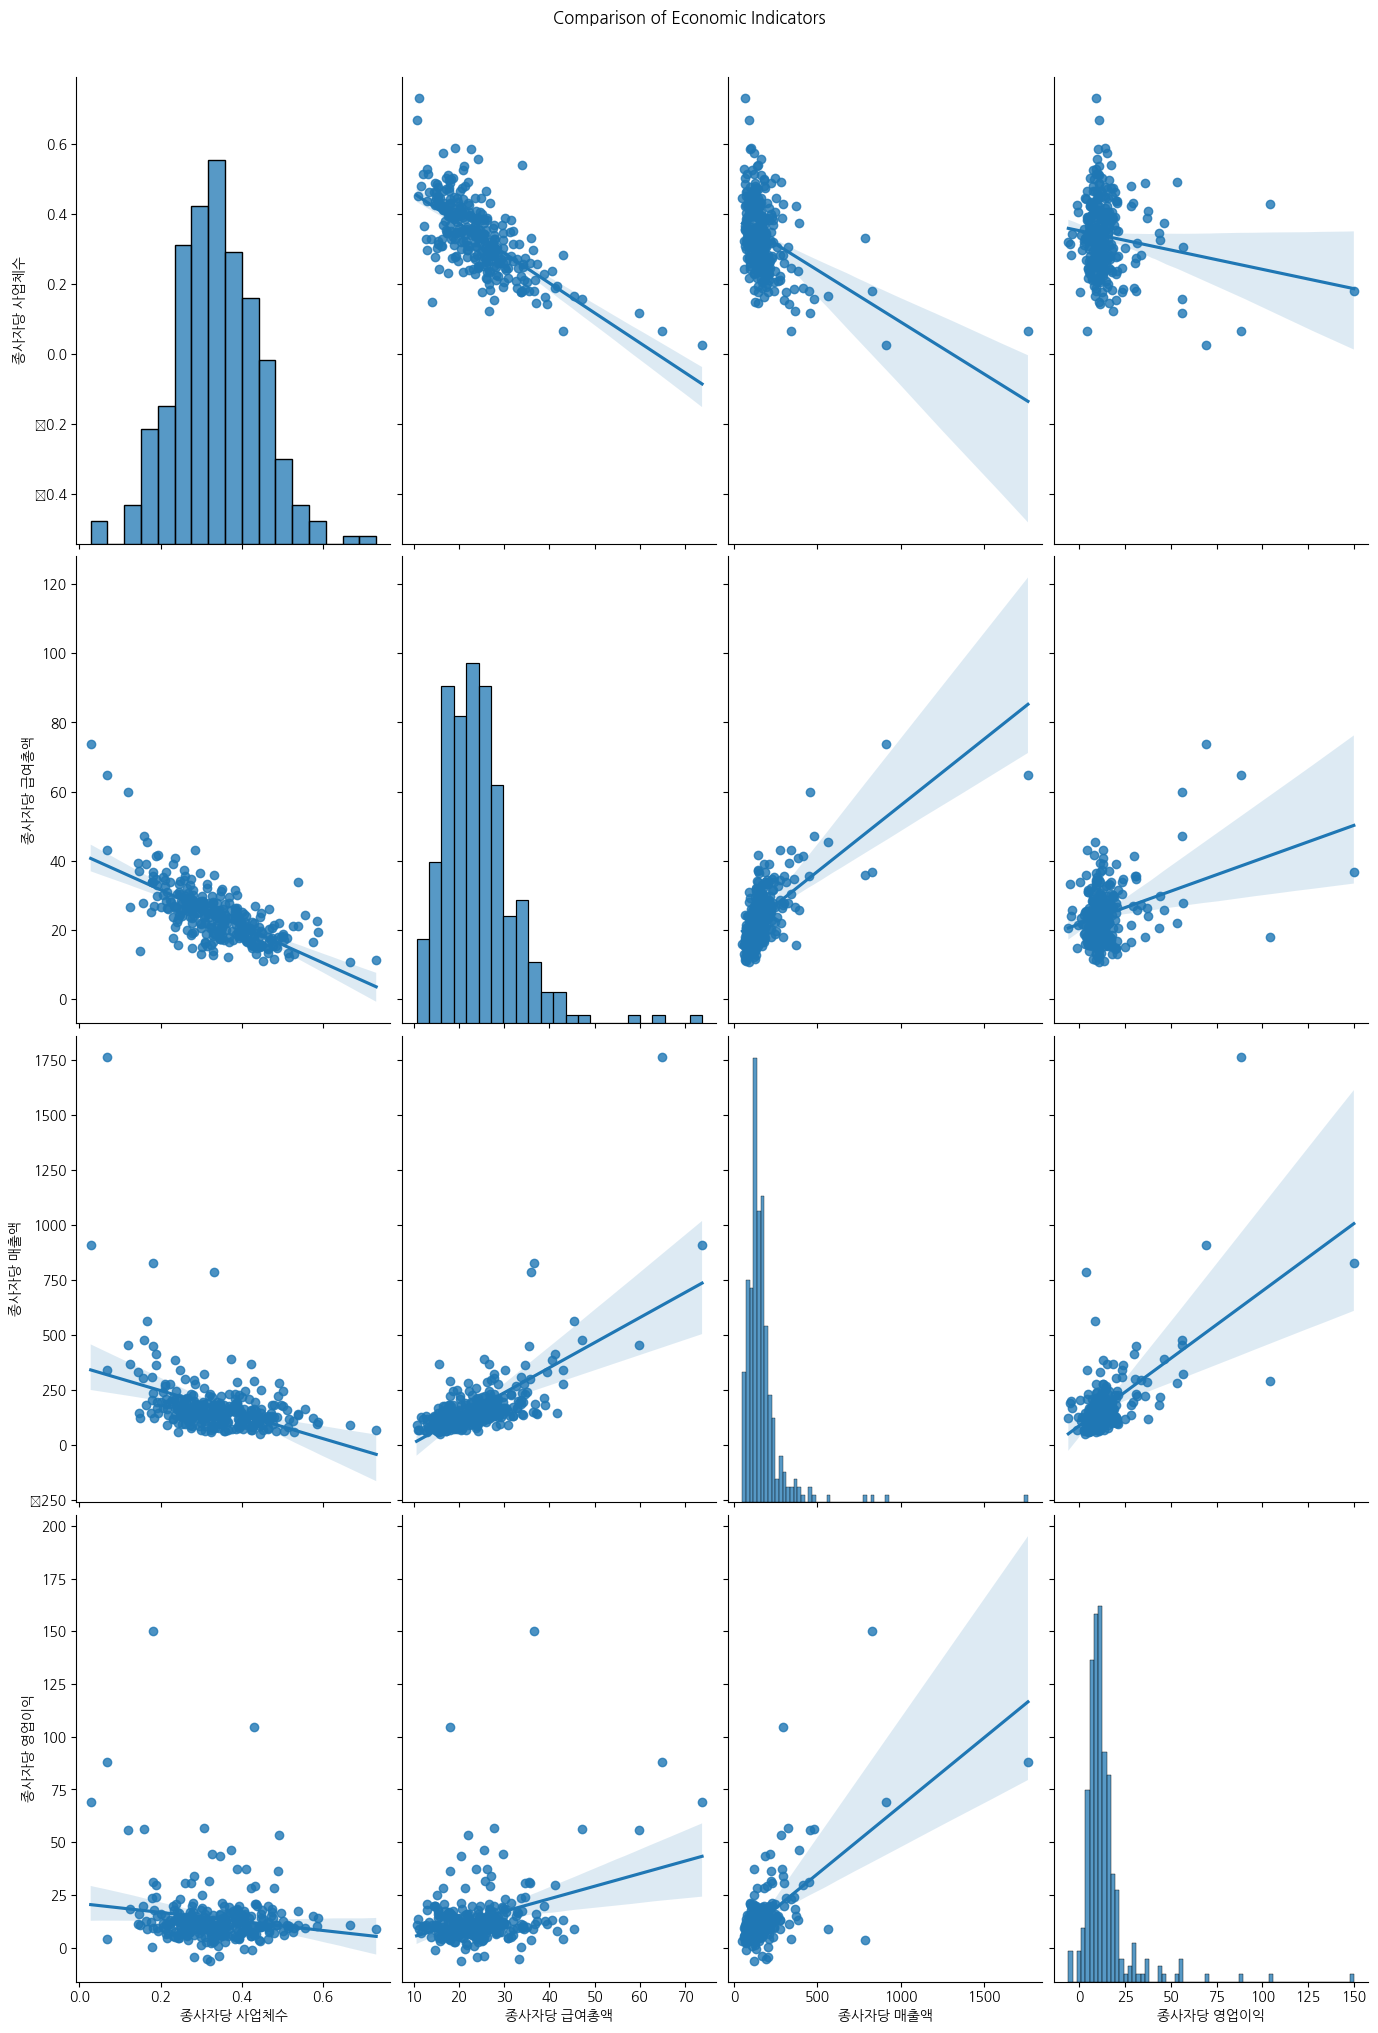

In [15]:
# pairplot을 이용하여 경제지표간 선형관계 유무 확인
plt.figure(figsize=(12, 10))
sns.pairplot(df_econ, x_vars=econ_vars, y_vars=econ_vars, height=5, aspect=0.7, kind='reg')
plt.suptitle('Comparison of Economic Indicators', y=1.02)
plt.show()

---

### KMO 검정 및 Bartlett의 구형성 검정 수행
위 4개의 경제지표를 가지고 하나의 경제평가지표를 만들고자 한다.

Factor Analyzation을 진행하여 하나의 경제지표로 통합을 하기 전에 \
Factor Analyzation이 적용하기에 적합한 변수셋인지 KMO와 Bartlett Sphericity 검정을 해주겠다.

In [16]:
# 데이터 스케일링
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_econ[econ_vars]), columns=df_econ[econ_vars].columns)

# KMO 검정 및 Bartlett의 구형성 검정 수행
kmo_all, kmo_model = calculate_kmo(scaled_df)
bartlett_chi_square, bartlett_p_value = calculate_bartlett_sphericity(scaled_df)

# 결과 출력
print(f'KMO Model: {kmo_model}')
print(f'Bartlett Chi-Square: {bartlett_chi_square}')
print(f'Bartlett P-Value: {bartlett_p_value}')

KMO Model: 0.62703006532809
Bartlett Chi-Square: 490.74053905695024
Bartlett P-Value: 4.117463986301559e-103


모델의 KMO 값이 0.6 이상이고, Bartlett P값도 0에 가까워 Factor Analyzation을 수행하기 적합한 데이터인것을 볼 수 있습니다.

In [17]:
# Factor Analysis 수행
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(scaled_df)

# Factor Loadings 계산
loadings = pd.DataFrame(fa.loadings_, index=scaled_df.columns, columns=['Factor 1', 'Factor 2'])

# Variance Explained 계산
variance_explained = pd.DataFrame(fa.get_factor_variance(), index=['Variance', 'Proportion of Variance', 'Cumulative Variance'], columns=['Factor 1', 'Factor 2'])

pd.concat([loadings, variance_explained], axis=0)

Factor 1  Factor 2
종사자당 사업체수              -0.725871 -0.117959
종사자당 급여총액               0.866562  0.357737
종사자당 매출액                0.419006  0.830911
종사자당 영업이익               0.096597  0.707505
Variance                1.462717  1.332867
Proportion of Variance  0.365679  0.333217
Cumulative Variance     0.365679  0.698896

In [18]:
# 각 샘플의 요인 점수 계산
factor_scores = pd.DataFrame(fa.transform(scaled_df), columns=['Factor 1 Score', 'Factor 2 Score'])

# 통합적 경제지표를 계산 (평균 가중치)
weights = variance_explained.loc['Proportion of Variance'].values  # 각 요인이 설명하는 분산의 비율을 가중치로 사용
factor_scores['Economic Index'] = (factor_scores['Factor 1 Score'] * weights[0] + factor_scores['Factor 2 Score'] * weights[1]) / sum(weights)
df_econ['경제지표'] = factor_scores['Economic Index']

In [20]:
# 클러스터링 결과와 경제지표를 병합
df_merged = df_cluster_0.merge(df_econ[['행정구역(읍면동)', '경제지표']], 
                               left_on='행정읍면동명', right_on='행정구역(읍면동)', 
                               how='left').drop('행정구역(읍면동)', axis=1)

In [25]:
# DBSCAN cluster 군집별 경제지표 평균 계산
economic_index_mean = df_merged.groupby('DBSCAN_labels')['경제지표'].mean()
df_merged['군집 평균 경제지표'] = df_merged['DBSCAN_labels'].map(economic_index_mean)

# DBSCAN cluster 군집별 샘플 개수 계산
cluster_counts = df_merged['DBSCAN_labels'].value_counts()
df_merged['군집 샘플 수'] = df_merged['DBSCAN_labels'].map(cluster_counts)

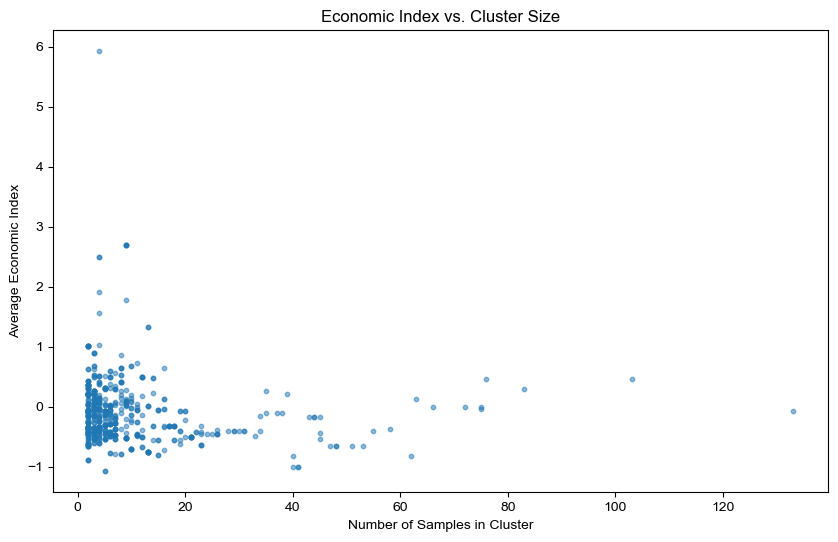

In [27]:
# 경제지표 평균 VS 샘플 개수 시각화
plt.figure(figsize=(10, 6))
plt.rc('font', family='Arial')
plt.scatter(cluster_counts[1:], economic_index_mean[1:], s=10, alpha=0.5)
plt.xlabel('Number of Samples in Cluster')
plt.ylabel('Average Economic Index')
plt.title('Economic Index vs. Cluster Size')
plt.show()

---
---